In [23]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import sympy
import scipy.io as sio

## Carga de la señal

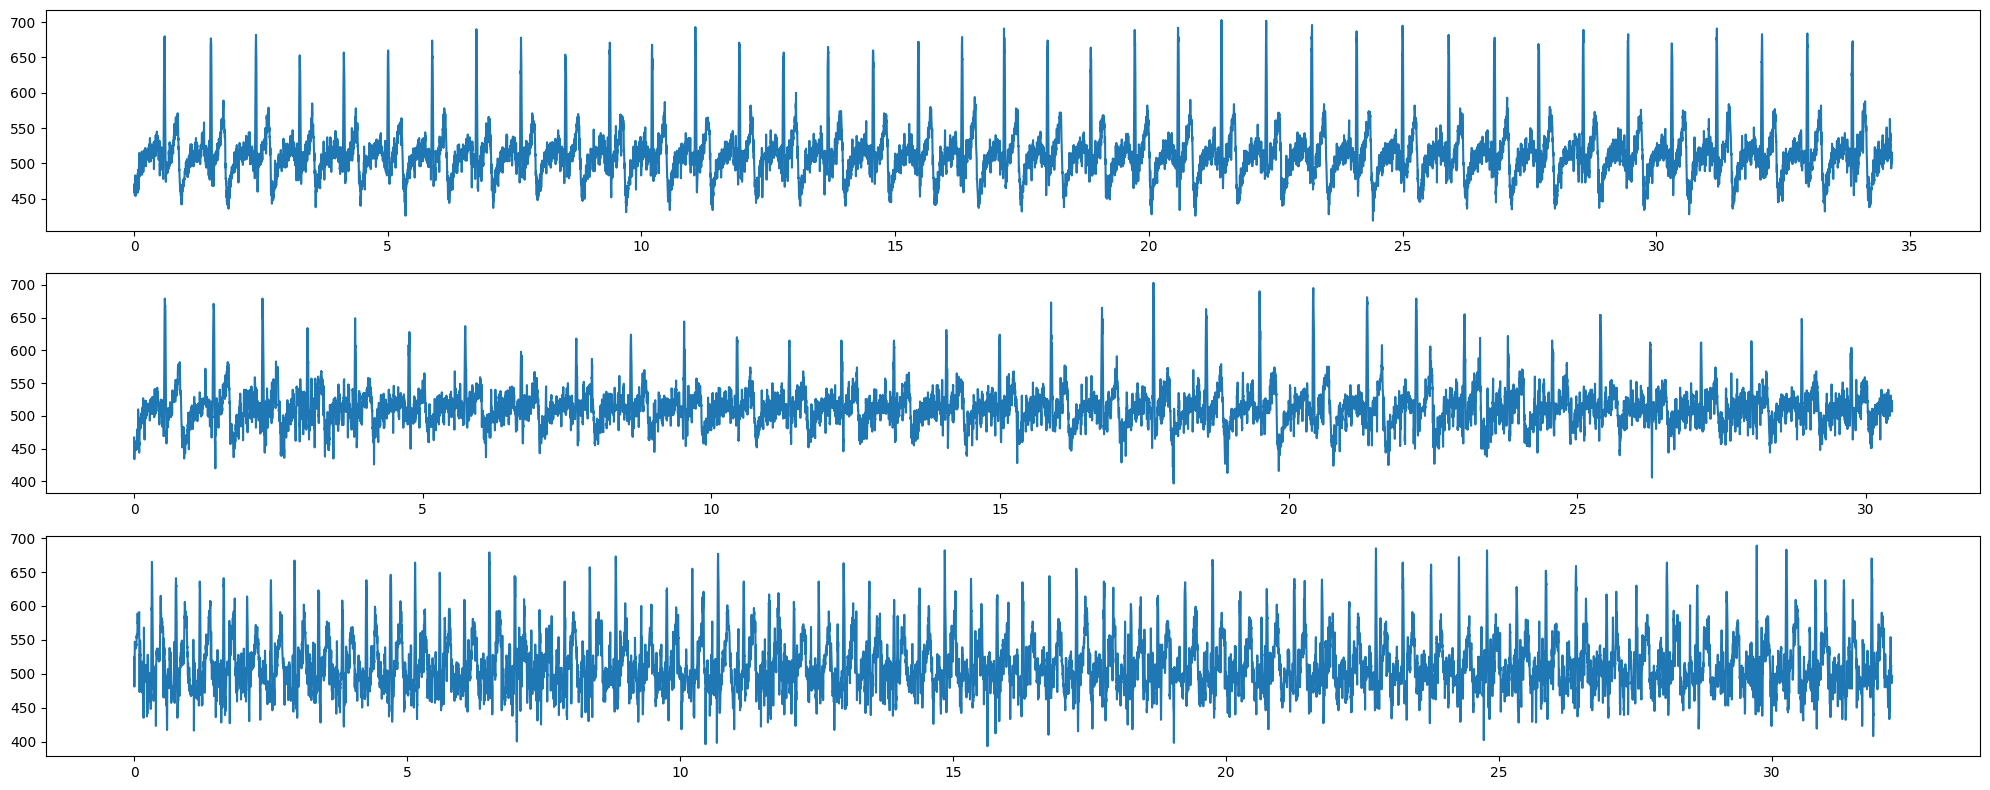

In [24]:
Fs=1000
Ts=1/Fs

# Señal Total
mat = sio.loadmat('Dataset.mat')
basal_full = mat['Basal 1'].flatten()
resp_full = mat['Respiracion'].flatten()
post_full = mat['Post-ejercicio'].flatten()

tbasal =  np.arange(len(basal_full))*Ts
tresp =  np.arange(len(resp_full))*Ts
tpost =  np.arange(len(post_full))*Ts

# Graficamos la señal
fig, axs=plt.subplots(3,1,figsize=(20,8))
axs[0].plot(tbasal,basal_full)
axs[1].plot(tresp,resp_full)
axs[2].plot(tpost,post_full)
plt.tight_layout()
plt.show()

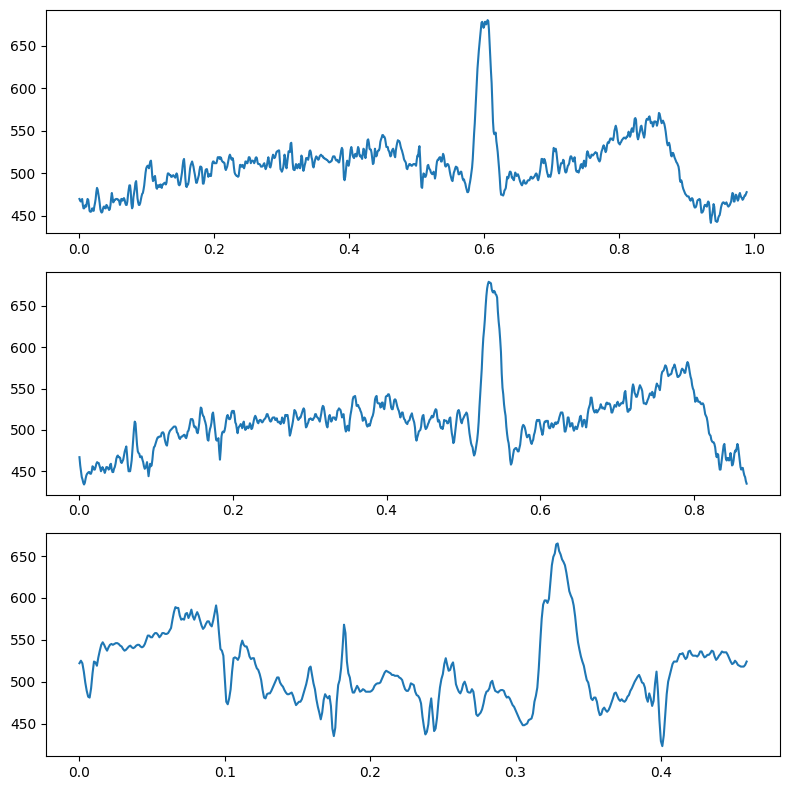

In [25]:
# Señal Parcial
mat = sio.loadmat('Dataset.mat')
basal = mat['Basal 1'][0]
resp = mat['Respiracion'][0]
post = mat['Post-ejercicio'][0]

tbasal =  np.arange(len(basal))*Ts
tresp =  np.arange(len(resp))*Ts
tpost =  np.arange(len(post))*Ts

# Graficamos la señal
fig, axs=plt.subplots(3,1,figsize=(8,8))
axs[0].plot(tbasal,basal)
axs[1].plot(tresp,resp)
axs[2].plot(tpost,post)
plt.tight_layout()
plt.show()


## Dominio de la frecuencia de la señales

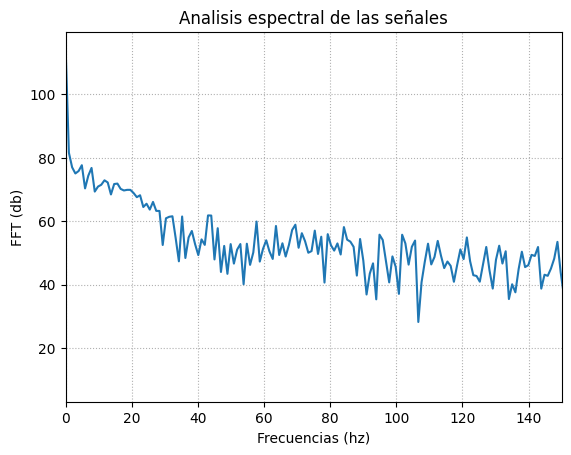

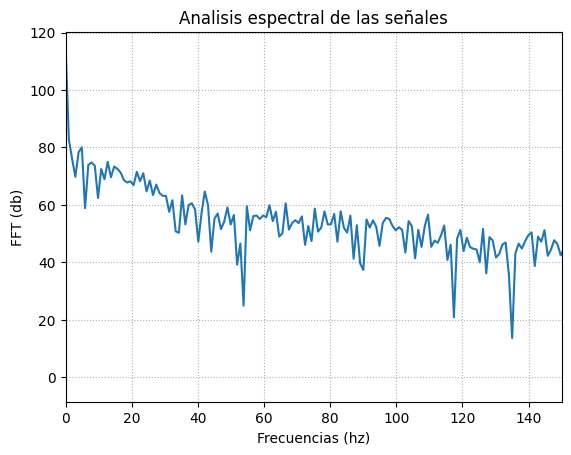

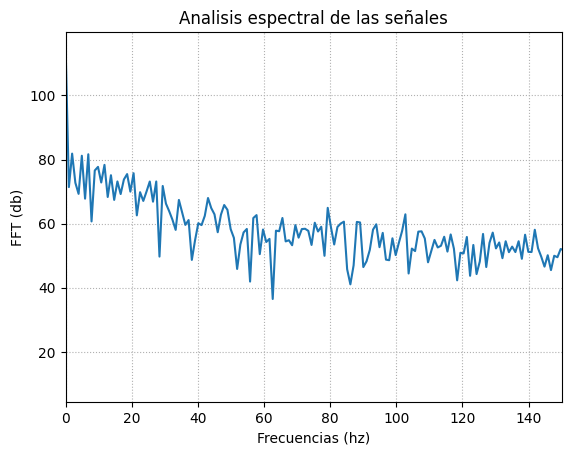

In [26]:
plot_FFT(basal_full,Fs)
plot_FFT(resp_full,Fs)
plot_FFT(post_full,Fs)

## Diseño del filtro pasa bajo 

In [27]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def plot_filterIIR(data):
    # Setting standard filter requirements.
    order = 8
    fs = 1000.0       
    cutoff = 100.0

    b, a = butter_lowpass(cutoff, fs, order)

    f = plt.figure(2, figsize = (8,8))
    # Plotting the frequency response.
    w, h = signal.freqz(b, a, worN=8000)
    plt.subplot(2, 1, 1)
    plt.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)), 'b')
    plt.title("Lowpass Filter Frequency Response (cutoff = 150 Hz)")
    plt.xlabel('Frequency [Hz]')
    plt.ylim(-5,0)
    plt.grid()

    # Filtering and plotting
    y = butter_lowpass_filter(data, cutoff, fs, order)
    plt.subplot(2, 1, 2)
    plt.plot(tbasal, data, 'b-', label='data')
    plt.plot(tbasal, y, 'g-', linewidth=2, label='filtered data')
    plt.grid(linestyle=":")
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud (mV)')
    plt.axhline(0.0, color='k')
    plt.xlim(0.5,0.7)
    plt.legend()

    plt.subplots_adjust(hspace=0.35)
    plt.tight_layout()
    plt.show()

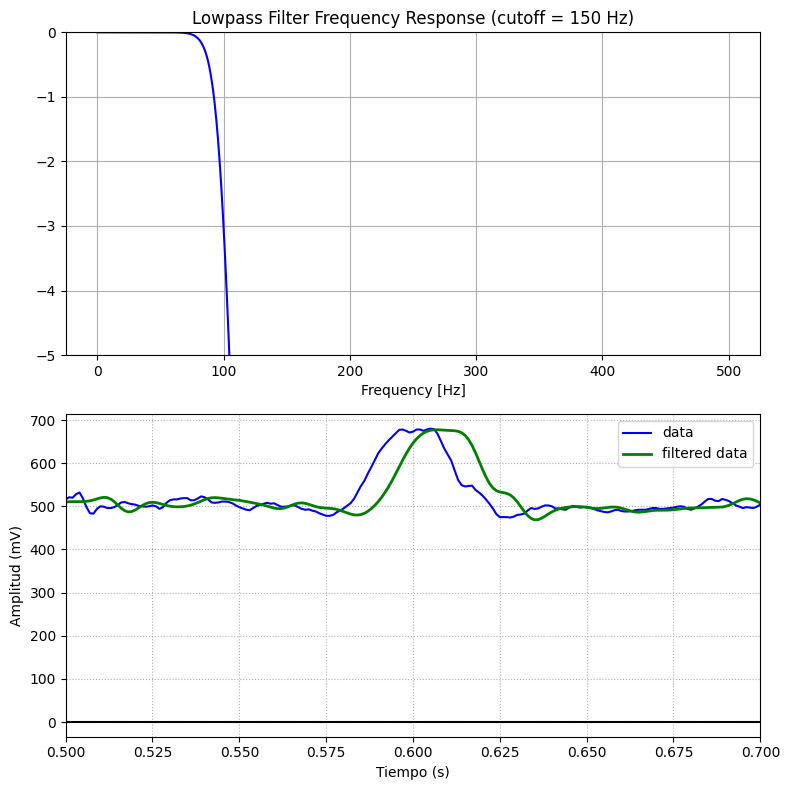

In [28]:
plot_filterIIR(basal)

In [29]:
# Funcion de transferencia del filtro pasa bajo analogico

# Creado con pyfda: Butterworth 20Hz 
b = np.array([6.50e-13, 6.50e-12, 2.93e-11, 7.80e-11, 1.37e-10, 1.64e-10, 1.37e-10, 7.80e-11, 2.93e-11, 6.50e-12, 6.50e-13])
a = np.array([1, -9.196736168, 38.09105884, -93.56278086, 150.9311664, -167.0769733, 128.5295681, -67.8479757, 23.52000946, -4.834875109, 0.447538372])

#np.set_printoptions(precision=3)
b,a

(array([6.50e-13, 6.50e-12, 2.93e-11, 7.80e-11, 1.37e-10, 1.64e-10,
        1.37e-10, 7.80e-11, 2.93e-11, 6.50e-12, 6.50e-13]),
 array([   1.        ,   -9.19673617,   38.09105884,  -93.56278086,
         150.9311664 , -167.0769733 ,  128.5295681 ,  -67.8479757 ,
          23.52000946,   -4.83487511,    0.44753837]))

Text(0, 0.5, 'Magnitud (db)')

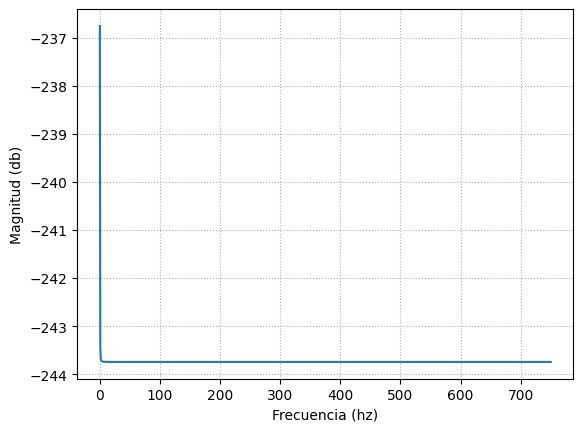

In [30]:
# Respuesta en frecuencia del filtro analogico
Fmax=750
F_freqs = np.linspace(0,Fmax,1000)
W_freqs = 2*np.pi*F_freqs  #Angular frecuences

W_freqs, H = signal.freqs(b,a,W_freqs)
Hm=np.abs(H)
plt.plot(F_freqs, 20 * np.log10(Hm))
plt.grid(linestyle=":")
plt.xlabel("Frecuencia (hz)")
plt.ylabel("Magnitud (db)")

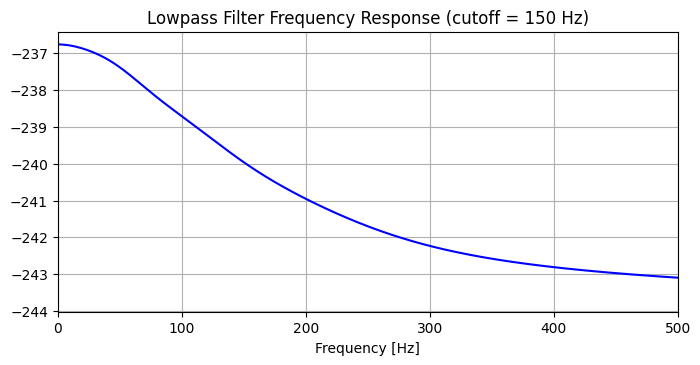

In [31]:
f = plt.figure(2, figsize = (8,8))
fs = Fs
# Plotting the frequency response.
w, h = signal.freqs(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)), 'b')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response (cutoff = 150 Hz)")
plt.xlabel('Frequency [Hz]')
plt.grid()

## TRansformada bilineal de H(s) a H(z)

Text(0, 0.5, 'Magnitud (db)')

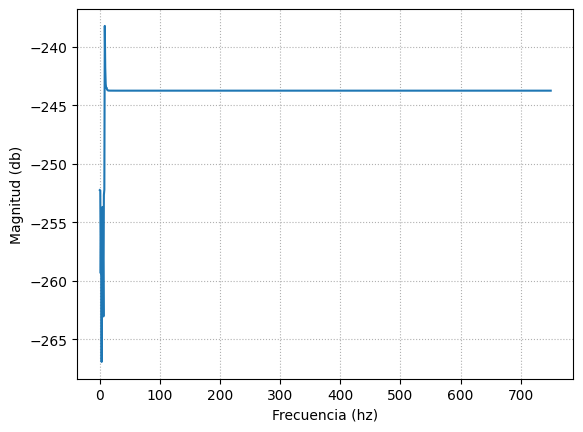

In [32]:
bd, ad = signal.bilinear(b,a,Fs)

Wz, Hd = signal.freqz(bd, ad, W_freqs/Fs)

Hdm = np.abs(Hd)
plt.plot(F_freqs, 20 * np.log10(Hdm))
plt.grid(linestyle=":")
plt.xlabel("Frecuencia (hz)")
plt.ylabel("Magnitud (db)")

## Filtrado

In [33]:
y = signal.lfilter(bd,ad, x3)

fig, ax = plt.subplots(2,1)
ax[0].plot(t,y, label="y")
ax[0].legend(loc="upper right")
ax[0].grid()
ax[1].plot(t,x1, label="x1")
ax[1].legend(loc="upper right")
ax[1].grid()
ax[1].set_xlabel("tiempo (s)")

NameError: name 'x3' is not defined

Text([99.21798631], [1773.42580331], '99.0 hz')

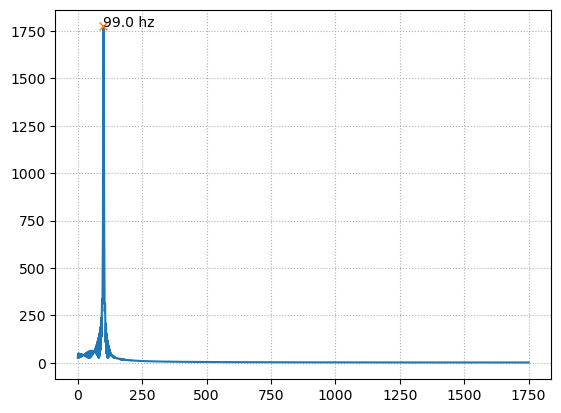

In [ ]:
N=2048

Yf = np.fft.fft(y,N)
Yf = Yf[:N//2]
Ym = np.abs(Yf)

Fd = np.linspace(0, Fs//2, N//2)
plt.plot(Fd, Ym)
plt.grid(linestyle=":")

peaks, properties = signal.find_peaks(Ym, height=500)
plt.plot(Fd[peaks], properties['peak_heights'], "x")
plt.text(Fd[peaks], properties['peak_heights'], f"{np.round(Fd[peaks][0])} hz")

## Test Tf 2 SoS

In [ ]:
bd, ad

(array([8.31111169e-10, 8.31111169e-09, 3.74000026e-08, 9.97333402e-08,
        1.74533345e-07, 2.09440015e-07, 1.74533345e-07, 9.97333402e-08,
        3.74000026e-08, 8.31111169e-09, 8.31111169e-10]),
 array([   1.        ,   -8.28887191,   31.04279749,  -69.15733541,
         101.47293922, -102.44471427,   72.05717753,  -34.86201333,
          11.10147231,   -2.10083904,    0.17938827]))

In [ ]:
#sos1 = signal.tf2sos(bd,ad)
#sos1.shape

In [ ]:
[1]+[0]

[1, 0]

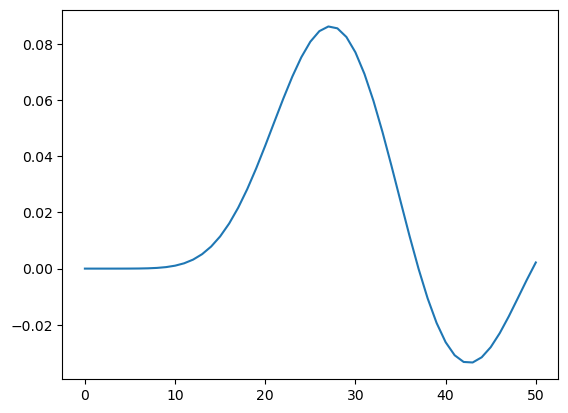

In [ ]:
sos2 = signal.lfilter(bd,ad, [1]+[0]*50)
#print(sos2)
plt.plot(sos2)

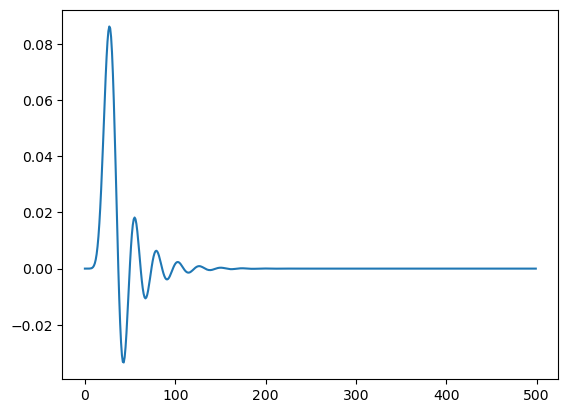

In [ ]:
tt, yy = signal.dimpulse((bd,ad,Fs), n=500)
plt.plot(np.squeeze(yy))

(0.0, 0.1)

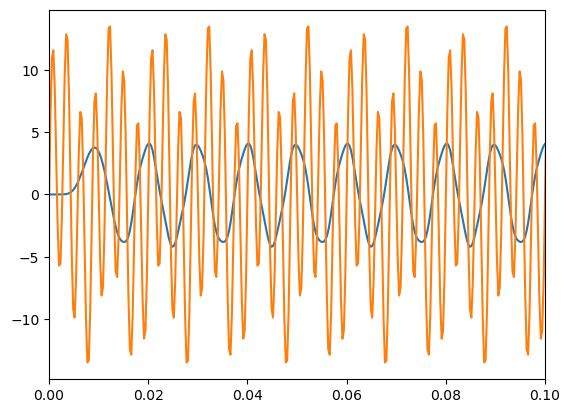

In [ ]:
y3 = signal.lfilter(sos2,[1], x3)
#print(sos2)
plt.plot(t,y3)
plt.plot(t,x3)
plt.xlim(0,0.1)

Text([99.21798631], [1774.84085137], '99.0 hz')

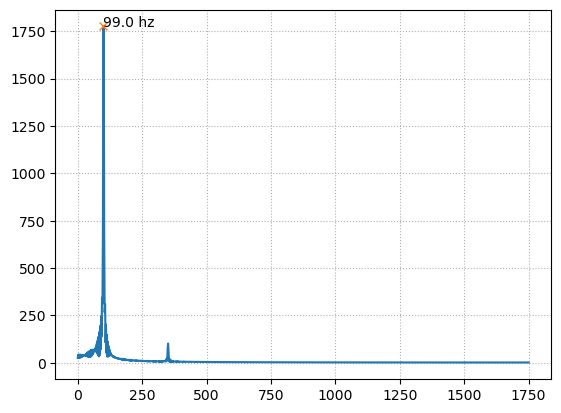

In [ ]:
N=2048

Yf = np.fft.fft(y3,N)
Yf = Yf[:N//2]
Ym = np.abs(Yf)

Fd = np.linspace(0, Fs//2, N//2)
plt.plot(Fd, Ym)
plt.grid(linestyle=":")

peaks, properties = signal.find_peaks(Ym, height=500)
plt.plot(Fd[peaks], properties['peak_heights'], "x")
plt.text(Fd[peaks], properties['peak_heights'], f"{np.round(Fd[peaks][0])} hz")